In [105]:
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
from qiskit.circuit.library import HGate, DiagonalGate
from numpy.typing import NDArray
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from typing import Any
import csv
from datetime import datetime

In [106]:
def encode(variable: NDArray[np.float64], link_qubits: int) -> Statevector:

    state = variable.flatten()
    # Check if length is a power of 2
    if not (len(state) & (len(state) - 1) == 0):
        raise ValueError("Length of flattened array must be a power of 2")
    

    state = Statevector(state / np.linalg.norm(state))
    ancilla = Statevector([1.0, 0.0])
    for _ in range(link_qubits):
        state = state.expand(ancilla)

    
    return state.expand(ancilla)

In [107]:
def get_ctrl_qubits(binary_str: str)-> tuple[list[int], int, str]:
    length = len(binary_str)
    for i, bit in enumerate(binary_str):
        if i == length - 1:
            raise ValueError("Invalid binary representation")
        if bit == '1':
            return (list(range(length - i - 1)), length - i - 1, binary_str[i+1:])
    raise ValueError("Invalid binary representation")

In [ ]:
def encode_links(link_qubits: int, num_links: int) -> Gate:
    floor_qubits = int(np.floor(np.log2(num_links)))
    floor_links = 2**floor_qubits
    qc = QuantumCircuit(link_qubits)

    for i in range(link_qubits):
        qc.h(i)

    # for i in range(floor_links, num_links):
    #     bin_repr = np.binary_repr(i, link_qubits)
    #     (ctrl_qubits, target_qubit, state) = get_ctrl_qubits(bin_repr)
    #     qc.append(HGate().control(num_ctrl_qubits=len(state), ctrl_state=state), ctrl_qubits + [target_qubit])
    
    return qc.to_gate(label='Link encoding')

In [109]:
def recover_quantity_classical_macros(state: Statevector, site_dims: list[int], num_links: int, original_norm: np.float64) -> NDArray[np.float64]:
    # Get the statevector as numpy array
    state_array = np.array(state)
    
    # Calculate total number of sites
    num_sites = np.prod(site_dims)
    
    # Initialize density array
    density = np.zeros(site_dims, dtype=complex)
    
    # Sum up contributions from each link direction
    for i in range(num_links):
        # Extract values for this link direction
        start_idx = i * num_sites
        end_idx = (i + 1) * num_sites
        link_vals = state_array[start_idx:end_idx]
        
        # Reshape and add to total density
        density += link_vals.reshape(site_dims)
    
    density = np.real(density)
    return original_norm * density / np.linalg.norm(density)

In [110]:
def recover_quantity_quantum_macros(state: Statevector, site_dims: list[int], num_links: int, original_norm: np.float64) -> NDArray[np.float64]:
    # Get the statevector as numpy array
    state_array = np.array(state)
    
    # Calculate total number of sites
    num_sites = np.prod(site_dims)
    
    # Initialize density array
    density = state_array[:num_sites].reshape(site_dims)
    
    density = np.real(density)
    return original_norm * density / np.linalg.norm(density)

In [111]:
def get_renorm_coeff(num_velocities: int) -> NDArray[np.float64]:
    floor_qubits = int(np.floor(np.log2(num_velocities)))
    full_velocities = 2**floor_qubits

    coeffs = np.full(num_velocities,2.0)
    for i in range(num_velocities - full_velocities):
        coeffs[i] *= np.sqrt(2)
        coeffs[-i - 1] *= np.sqrt(2)

    return coeffs

In [112]:
def lambda_gate(lambda_val: np.float64) -> Gate:
    qc = QuantumCircuit(1, name='lambda')
    qc.p(lambda_val, 0)
    qc.x(0)
    qc.p(lambda_val, 0)
    qc.x(0)

    return qc.to_gate(label=f'lambda{lambda_val:.2f}')

In [113]:
def c_gate(lambdas: NDArray[np.float64], link_qubits: int) -> Gate:
    qc = QuantumCircuit(link_qubits + 1)

    controls = list(range(1, link_qubits + 1))
    target = 0

    for i in range(len(lambdas)):
        control_state = np.binary_repr(i, link_qubits)
        qc.append(lambda_gate(lambdas[i]).control(link_qubits, ctrl_state=control_state), controls + [target])
    
    return qc.to_gate(label='C')

In [114]:
def collision(lambdas: NDArray[np.float64], site_qubits: int, link_qubits: int) -> QuantumCircuit:
    num_qubits = site_qubits + link_qubits + 1
    qc = QuantumCircuit(num_qubits)
    
    ancilla = num_qubits - 1
    targets = [0] + list(range(site_qubits, num_qubits - 1))

    qc.h(ancilla)
    qc.append(c_gate(lambdas, link_qubits).control(1, ctrl_state='0'), [ancilla] + targets)
    qc.append(c_gate(-1 * lambdas, link_qubits).control(1, ctrl_state='1'), [ancilla] + targets)
    qc.h(ancilla)

    return qc

In [115]:
def get_collision_diagonal(link_qubits: int, links: list[list[int]], weights: list[float], velocity_field: NDArray[np.float64], speed_of_sound: np.float64):
    num_links = len(links)
    renorm_coeffs = get_renorm_coeff(num_links)
    
    dimension = list(velocity_field.shape)[0]
    velocity_field = velocity_field.reshape(dimension, -1)
    field_size = len(velocity_field[0])

    max_links = 2**link_qubits
    
    blocks = []
    for i, link in enumerate(links):
        link_velocity = np.sum([link[d]*velocity_field[d] for d in range(dimension)], axis=0)
        block = weights[i] * renorm_coeffs[i] * (1 + link_velocity / (speed_of_sound ** 2))
        blocks.append(block)

    for _ in range(num_links, max_links):
        blocks.append(np.ones(field_size))


    matrix = np.concatenate(blocks)
        
    return matrix

In [116]:
def collision_nonuniform(site_qubits: int, link_qubits: int, collision_matrix: NDArray[np.float64]) -> QuantumCircuit:
    num_qubits = site_qubits + link_qubits + 1
    qc = QuantumCircuit(num_qubits)
    
    ancilla = num_qubits - 1
    target_qubits = list(range(ancilla))

    unitary_1 = list(collision_matrix + 1.j*np.sqrt(1 - np.square(collision_matrix)))
    unitary_2 = list(collision_matrix - 1.j*np.sqrt(1 - np.square(collision_matrix)))

    qc.h(ancilla)
    qc.append(DiagonalGate(unitary_1).control(ctrl_state='0'), [ancilla] + target_qubits)
    qc.append(DiagonalGate(unitary_2).control(ctrl_state='1'), [ancilla] + target_qubits)
    qc.h(ancilla)

    return qc

In [117]:
links = [[0,0],[-1,0],[1,0],[0,-1],[0,1]]
weights = [2/6, 1/6, 1/6, 1/6, 1/6]
speed_of_sound = 1/np.sqrt(3)

velocity_filed = np.ones(shape=[2,2,2])
collision_matrix = get_collision_diagonal(3,links, weights, velocity_filed, speed_of_sound)
print(list(collision_matrix))
unitary_1 = list(collision_matrix + 1.j*np.sqrt(1 - np.square(collision_matrix)))
print(unitary_1)
#unitary_2 = list(collision_matrix - 1.j*np.sqrt(1 - np.square(collision_matrix)))

[np.float64(0.9428090415820634), np.float64(0.9428090415820634), np.float64(0.9428090415820634), np.float64(0.9428090415820634), np.float64(-0.6666666666666663), np.float64(-0.6666666666666663), np.float64(-0.6666666666666663), np.float64(-0.6666666666666663), np.float64(1.333333333333333), np.float64(1.333333333333333), np.float64(1.333333333333333), np.float64(1.333333333333333), np.float64(-0.6666666666666663), np.float64(-0.6666666666666663), np.float64(-0.6666666666666663), np.float64(-0.6666666666666663), np.float64(1.8856180831641263), np.float64(1.8856180831641263), np.float64(1.8856180831641263), np.float64(1.8856180831641263), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
[np.complex128(0.9428090415820634+0.3333333333333334j), np.complex128(0.9428090415820634+0.3333333333333334j), np.complex128(0.9428090415820634+0.33333

C:\Users\tavaa\AppData\Local\Temp\ipykernel_25636\818113076.py:8: RuntimeWarning: invalid value encountered in sqrt
  unitary_1 = list(collision_matrix + 1.j*np.sqrt(1 - np.square(collision_matrix)))


In [118]:
def r_gate(num_qubits: int) -> Gate:
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits - 1, -1, -1):
        if i == 0:
            qc.x(i)
        else:
            controls = list(range(0, i))
            qc.mcx(controls, i)
    
    return qc.to_gate(label='R')

def l_gate(num_qubits: int) -> Gate:
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        if i == 0:
            qc.x(i)
        else:
            controls = list(range(0, i))
            qc.mcx(controls, i)
    
    return qc.to_gate(label='L')


In [119]:
def propagation(site_qubits: list[int], link_qubits: int, links: list[list[int]]) -> QuantumCircuit:
    
    tot_site_qubits = np.sum(site_qubits)
    num_qubits = tot_site_qubits + link_qubits
    qc = QuantumCircuit(num_qubits)
    
    targets = [list(range(sum(site_qubits[:i]), sum(site_qubits[:i+1]))) for i in range(len(site_qubits))]
    
    controls = list(range(tot_site_qubits, num_qubits))
    for i, link, in enumerate(links):
        control_state = np.binary_repr(i, link_qubits)
        for j, dir in enumerate(link):
            #perform left streaming 'dir' cells away
            while dir < 0:
                qc.append(l_gate(site_qubits[j]).control(link_qubits, ctrl_state=control_state), controls + targets[j])
                dir += 1
            #perform right streaming 'dir' cells away
            while dir > 0:
                qc.append(r_gate(site_qubits[j]).control(link_qubits, ctrl_state=control_state), controls + targets[j])
                dir -= 1
    return qc

In [120]:
def macros(link_qubits: int) -> QuantumCircuit:
    qc = QuantumCircuit(link_qubits + 1)

    ancilla = link_qubits
    
    for i in range(link_qubits):
        qc.swap(i,ancilla)
        qc.h(ancilla)
    
    return qc

In [121]:
def animate_density_evolution(filename: str, interval: int = 100, repeat: bool = False) -> FuncAnimation:
    # Read the CSV file
    df = pd.read_csv(filename, header=None)
    
    # Calculate grid dimensions from the data
    grid_size = int(np.sqrt(len(df.columns)))
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    img = ax.imshow(np.zeros((grid_size, grid_size)), cmap='viridis', animated=True)
    plt.colorbar(img)
    
    ax.set_title('Density Evolution')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    def init():
        img.set_array(np.zeros((grid_size, grid_size)))
        return [img]
    
    def update(frame):
        # Reshape the flattened data back to 2D
        current_density = df.iloc[frame].values.reshape(grid_size, grid_size)
        img.set_array(current_density)
        img.set_clim(vmin=df.values.min(), vmax=df.values.max())
        return [img]
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=len(df),
                        init_func=init, blit=True,
                        interval=interval, repeat=repeat)
    
    return anim

In [122]:
def display_density_heatmap(density: NDArray[np.float64], title: str = 'Density Distribution'):
    plt.figure(figsize=(8, 6))
    heatmap = plt.imshow(density, cmap='viridis')
    plt.colorbar(heatmap, label='Density')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

In [123]:
def simulate_flow(initial_density: NDArray[np.float64],
                 velocity_field: NDArray[np.float64],
                 links: list[list[int]],
                 weights: list[float],
                 speed_of_sound: np.float64,
                 iterations: int,
                 filename: str,
                 initial: bool,
                 enable_quantum_macros: bool) -> NDArray[np.float64]:

    import time

    # Get original norm for proper normalization
    original_norm = np.float64(np.linalg.norm(initial_density))
    # Convert numpy shape to list of integers
    sites_per_dim = list(initial_density.shape)
    site_qubits_per_dim = [int(np.ceil(np.log2(sites))) for sites in sites_per_dim]
    site_qubits = np.sum(site_qubits_per_dim)

    num_links = len(links)
    link_qubits = int(np.ceil(np.log2(num_links)))

    collision_matrix = get_collision_diagonal(link_qubits,links, weights, velocity_field, speed_of_sound)
    
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        # Write initial state as first row
        if initial:
            writer.writerow(initial_density.flatten())
        
        # Initialize state
        state = encode(initial_density, link_qubits)
        if state.num_qubits is None:
            raise ValueError("Failed to initialize quantum state")
        
        # Create quantum circuit for one iteration
        qc = QuantumCircuit(state.num_qubits)
        qc.append(encode_links(link_qubits, num_links), list(range(site_qubits, state.num_qubits -1)))
        qc.append(collision_nonuniform(site_qubits, link_qubits, collision_matrix), list(range(state.num_qubits)))
        qc.append(propagation(site_qubits_per_dim, link_qubits, links), list(range(0, state.num_qubits - 1)))

        recover_quantity = recover_quantity_classical_macros
        if enable_quantum_macros:
            qc.append(macros(link_qubits), list(range(site_qubits, state.num_qubits)))
            recover_quantity = recover_quantity_quantum_macros
        
        # Evolution loop
        last_time = time.time()
        for i in range(iterations):
            # Evolve state
            print(f"Iteration {i+1} running...")
            state = state.evolve(qc)
            
            # Recover density and normalize
            density = recover_quantity(state, sites_per_dim, num_links, original_norm)
            
            # Write current state to CSV
            writer.writerow(density.flatten())
            
            # Print time taken for this iteration
            current_time = time.time()
            print(f"Iteration {i+1}/{iterations} took {current_time - last_time:.3f} seconds")
            last_time = current_time
            
            # Re-encode for next iteration
            state = encode(density, link_qubits)

        return density

In [124]:
def visualize_velocity_field(velocity_field: NDArray[np.float64], title: str = 'Velocity Field') -> None:
    """
    Visualize a 2D velocity field using quiver plot.
    
    Args:
        velocity_field: Array of shape (2, height, width) containing x and y components of velocity
        title: Title of the plot
    """
    # Get dimensions of the field
    _, height, width = velocity_field.shape
    
    # Create coordinate meshgrid
    y, x = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    
    # Extract x and y components of velocity
    u = velocity_field[0]  # x-component
    v = velocity_field[1]  # y-component
    
    # Calculate velocity magnitude for color mapping
    magnitude = np.sqrt(u**2 + v**2)
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Plot velocity vectors with magnitude-based coloring
    plt.quiver(x, y, u, v, magnitude, 
               cmap='viridis',
               scale=30,
               width=0.005)
    
    plt.colorbar(label='Velocity magnitude')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

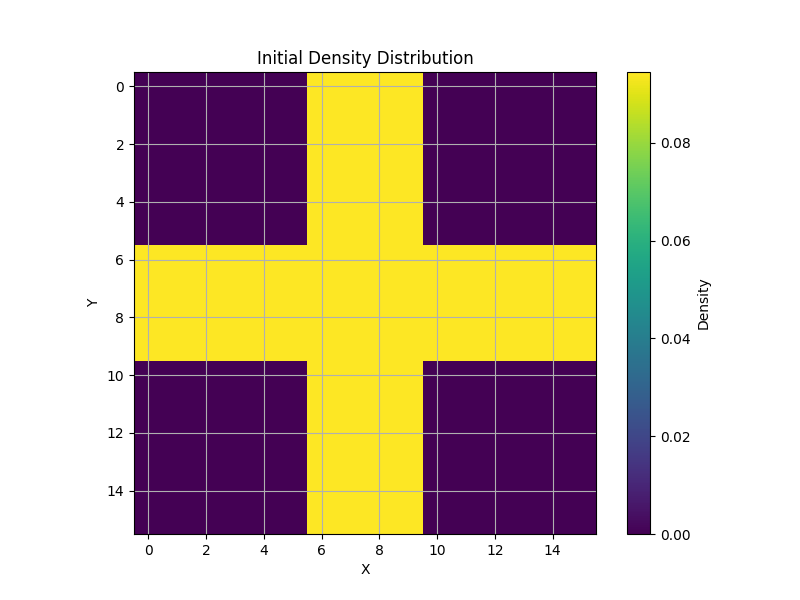

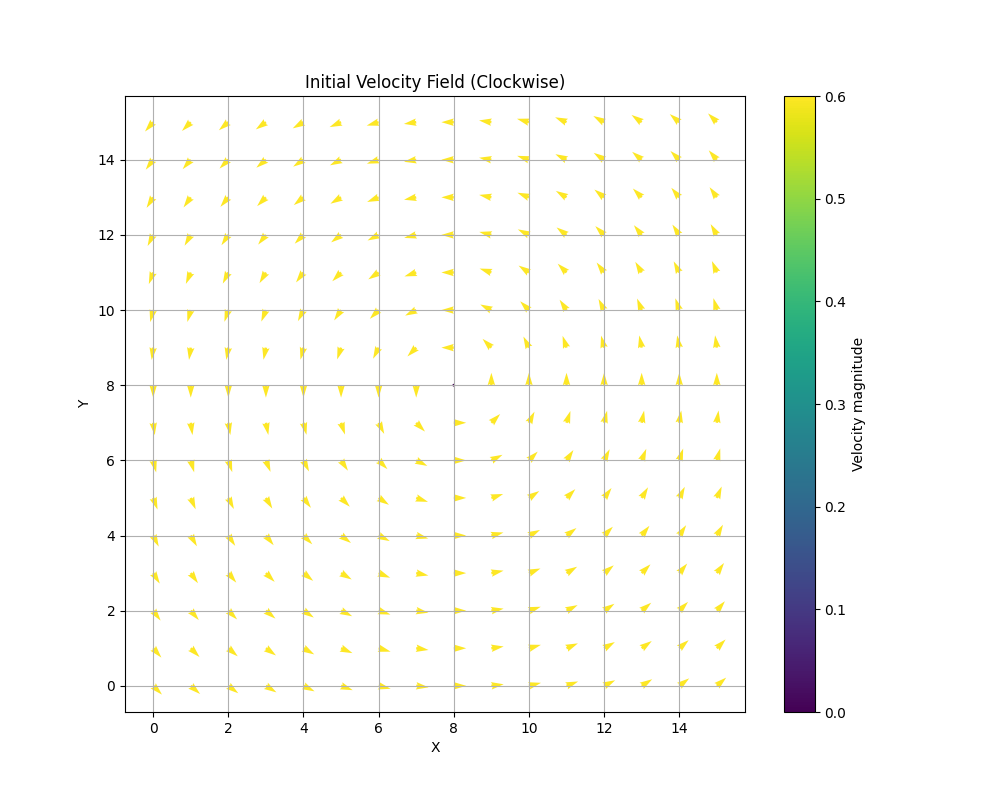

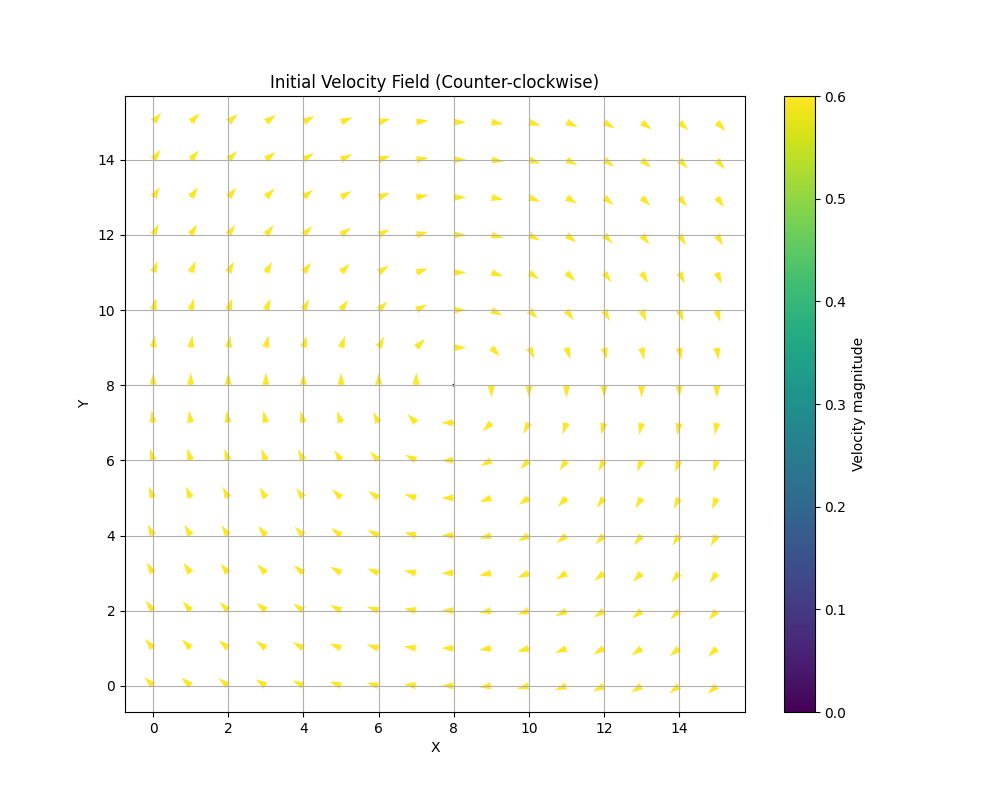

In [125]:
# Create initial configuration
sites = (16, 16)

links = [[0,0], [-1, 0], [1,0], [0,-1], [0,1]]
weights = [2/6, 1/6, 1/6, 1/6, 1/6]
speed_of_sound = 1/np.sqrt(3)

# Create a vortex velocity field
strength = 0.3  # Vortex strength
center = (sites[0]/2, sites[1]/2)  # Center of the vortex

x_coords = np.linspace(0, sites[0]-1, sites[0])
y_coords = np.linspace(0, sites[1]-1, sites[1])
x_grid, y_grid = np.meshgrid(x_coords, y_coords)

# Calculate distances from center
dx = x_grid - center[0]
dy = y_grid - center[1]
r = np.sqrt(dx**2 + dy**2)
r = np.where(r == 0, 1e-10, r)  # Avoid division by zero

# Create clockwise vortex field components
x_field_cw = -strength * dy / r
y_field_cw = strength * dx / r

# Create counter-clockwise vortex field components (opposite rotation)
x_field_ccw = strength * dy / r
y_field_ccw = -strength * dx / r

# Normalize velocities to avoid instabilities
max_vel_cw = max(np.max(np.abs(x_field_cw)), np.max(np.abs(y_field_cw)))
max_vel_ccw = max(np.max(np.abs(x_field_ccw)), np.max(np.abs(y_field_ccw)))

x_field_cw /= max_vel_cw
y_field_cw /= max_vel_cw
x_field_ccw /= max_vel_ccw
y_field_ccw /= max_vel_ccw

# Scale both fields
x_field_cw *= 0.6
y_field_cw *= 0.6
x_field_ccw *= 0.6
y_field_ccw *= 0.6

# Stack components into velocity fields
velocity_field_cw = np.stack([x_field_cw, y_field_cw])
velocity_field_ccw = np.stack([x_field_ccw, y_field_ccw])

# Initialize density array
density = np.zeros(sites)

# Create a cross pattern
width = 2  # Width of the cross arms

# Horizontal line
density[:, sites[1]//2-width:sites[1]//2+width] = 1.0

# Vertical line
density[sites[0]//2-width:sites[0]//2+width, :] = 1.0

# Normalize density
density /= np.linalg.norm(density)

# Visualize initial density
display_density_heatmap(density, title='Initial Density Distribution')
# Visualize both velocity fields
visualize_velocity_field(velocity_field_cw, title='Initial Velocity Field (Clockwise)')
visualize_velocity_field(velocity_field_ccw, title='Initial Velocity Field (Counter-clockwise)')

In [126]:
# Create unique filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"experiments/generic/density_evolution{timestamp}.csv"

cw_iterations = 15
ccw_iterations = 15
# Run simulation
density_1 = simulate_flow(density, velocity_field_cw, links, weights, speed_of_sound, cw_iterations, filename, initial=True, enable_quantum_macros=False)
density_1 = simulate_flow(density_1, velocity_field_ccw, links, weights, speed_of_sound, ccw_iterations, filename, initial=False, enable_quantum_macros=False)

print(f"Simulation complete. Results saved to {filename}")

C:\Users\tavaa\AppData\Local\Temp\ipykernel_25636\4191991842.py:8: RuntimeWarning: invalid value encountered in sqrt
  unitary_1 = list(collision_matrix + 1.j*np.sqrt(1 - np.square(collision_matrix)))
C:\Users\tavaa\AppData\Local\Temp\ipykernel_25636\4191991842.py:9: RuntimeWarning: invalid value encountered in sqrt
  unitary_2 = list(collision_matrix - 1.j*np.sqrt(1 - np.square(collision_matrix)))


CircuitError: 'A diagonal element does not have absolute value one.'

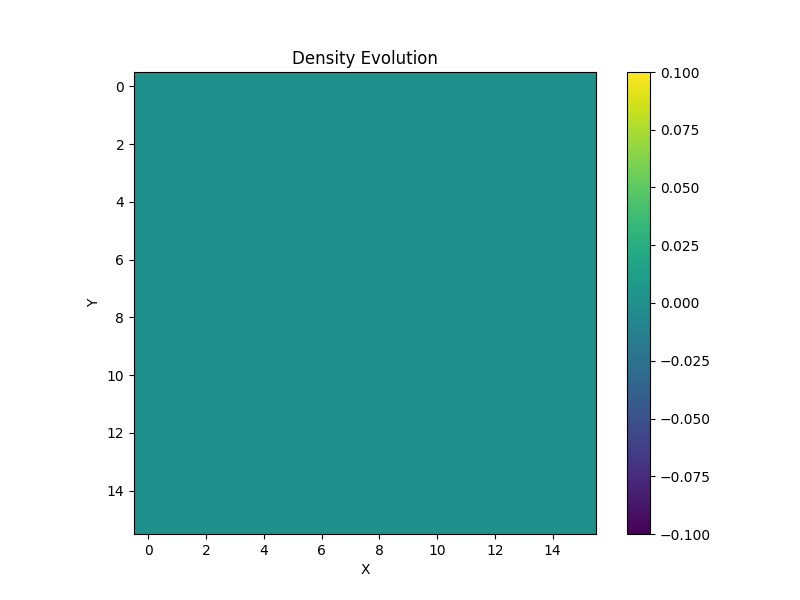

In [ ]:
# Create animation
%matplotlib widget
anim = animate_density_evolution(filename, interval=100)
plt.show()